In [1]:
import numpy as np
import sys
import time
import os
import pandas as pd
import math
import matplotlib.pyplot as plt


In [2]:
Start_time=time.time()

In [3]:
# load raw dataset
train_data=np.load('Assignment1-Dataset\\train_data.npy')
train_label=np.load('Assignment1-Dataset\\train_label.npy')
test_data=np.load('Assignment1-Dataset\\test_data.npy')
test_label=np.load('Assignment1-Dataset\\test_label.npy')
# Transforming label from number to one-hot
new_test_label = np.zeros([len(test_label), 10])
i = 0
for label in test_label:
    new_test_label[i, label] = 1
    i = i+1
test_label = new_test_label
new_train_label = np.zeros([len(train_label), 10])
i = 0
for label in train_label:
    new_train_label[i, label] = 1
    i = i+1
train_label = new_train_label


In [4]:
# normalizing data to range(1e-4,10+1e-3)
test_data = (test_data - np.min(test_data)+1e-4) / \
    (0.1*(np.max(test_data)-np.min(test_data)))
train_data = (train_data - np.min(train_data)+1e-4) / \
    (0.1*(np.max(train_data)-np.min(train_data)))

In [5]:
# Class to choosing and generating the Activation function
# By Activation, the shape will not be changed
class Activation(object):
    def __tanh(self, x):
        self.output = np.tanh(x)
        return self.output

    def __tanh_deriv(self, delta):
        self.output = 1.0-self.output**2
        delta = delta*self.output
        return delta

    def __logistic(self, x):
        self.output = 1.0 / (1.0 + np.exp(-x))
        return self.output

    def __logistic_deriv(self, delta):
        self.output = self.output*(1-self.output)
        delta = delta*self.output
        return delta

    def __ReLU(self, x):
        self.output = np.maximum(x, 0)
        return self.output

    def __ReLU_deriv(self, delta):
        self.output[self.output <= 0] = 0
        self.output[self.output > 0] = 1
        delta = delta*self.output
        return delta

    def __leaky_ReLU(self, x):
        self.output = np.where(x > 0, x, 0.5*x)
        return self.output

    def __leaky_ReLU_deriv(self, delta):
        self.output[self.output <= 0] = 0.5
        self.output[self.output > 0] = 1
        delta = delta*self.output
        return delta

    def __softmax(self, x):
        self.input = x
        self.output = np.zeros(self.input.shape)
        for i in range(self.input.shape[0]):
            in_r = x[i]
            output = np.exp(in_r)/(sum(np.exp(in_r)))
            self.output[i] = output
        return self.output

    def __softmax_deriv(self, delta):
        doutput = np.zeros(self.input.shape)
        for i in range(self.input.shape[0]):
            out_r = self.output[i]
            delta_r = delta[i]
            out_r = np.diag(out_r)-np.outer(out_r, out_r)
            out_r = np.dot(out_r, delta_r)
            doutput[i] = out_r
        # doutput=np.mean(doutput,axis=0)
        return doutput
# when instantiating a Activation class, choosing the activation function when initialization

    def __init__(self, activation='tanh'):
        if activation == 'logistic':
            self.forward = self.__logistic
            self.backward = self.__logistic_deriv
            self.predict = self.forward
        elif activation == 'tanh':
            self.forward = self.__tanh
            self.backward = self.__tanh_deriv
            self.predict = self.forward
        elif activation == 'ReLU':
            self.forward = self.__ReLU
            self.backward = self.__ReLU_deriv
            self.predict = self.forward
        elif activation == 'softmax':
            self.forward = self.__softmax
            self.backward = self.__softmax_deriv
            self.predict = self.forward
        elif activation == 'leaky_ReLU':
            self.forward = self.__leaky_ReLU
            self.backward = self.__leaky_ReLU_deriv
            self.predict = self.forward


In [6]:
# Class to define the hidden layer. It also include the weight decay and dropout
class Hiddenlayer(object):
    '''
    n_in: the number of input dimension
    n_out: the number of output dimension
    decay: the parameter of weight decay(should not too big, such as 1e-6)
    dropout: the ratio of dropped nodes(present with probability 1-dropout)
    when instantiating a hiddenlayer class, make sure that n_in is same to the n_out(or the dimension) of last layers
    when do not initial decay or dropout, they will not open
    w is weight. Shape is (n_in,n_out)
    b is bias. Shape is (n_out)
    grad_w is gradient of weight. Its shape is as same as weight w
    grad_b is gradient of bias. Its shape is as same as bias b
    '''

    def __init__(self, n_in, n_out, decay=None, dropout=None):
        self.w = np.random.randn(n_in, n_out) * np.sqrt(2.0/(n_in))
        self.b = np.zeros(n_out)
        self.grad_w = np.zeros(self.w.shape)
        self.grad_b = np.zeros(self.b.shape)
        self.decay = decay
        self.dropout = dropout

    def forward(self, input):
        # input shape is (n*n_in). n is the number of samples/ batch size
        self.input = input
        # when dropout has the value
        if self.dropout:
            # generating mask. Shape is as same as bias b
            self.boolean_mask = (np.random.rand(
                *self.b.shape) > self.dropout)/(1-self.dropout)
            self.output = np.dot(input, self.w) + self.b
            self.output *= self.boolean_mask  # mask nodes
        else:
            self.output = np.dot(input, self.w) + self.b
            # output shape is (n*n_out). n is the number of samples/ batch size
        return self.output

    def backward(self, delta):
        # delta shape is (n*n_out)
        # when dropout has the value
        if self.dropout:
            new_delta = delta
            # mask delta
            delta *= self.boolean_mask
            # calculating gradient of Weight
            self.grad_w = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        else:
            self.grad_w = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        # when decay has the value
        if self.decay:
            # adding weight decay
            self.grad_w += self.compute_reg_term_deriv()
        new_delta = delta
        # calculating gradient of bias
        self.grad_b = np.mean(delta, axis=0)
        # calculating delta
        new_delta = new_delta.dot(self.w.T)
        # new_delta shape is (n*n_in)
        return new_delta

    def step(self, opt, mpara):
        # calculating delta_w and delta_b by gradient, learning rate and optimizer
        # shape(dw)=shape(grad_w),shape(db)=shape(grad_b),new_mpara and mpara has the same structure
        dw, db, new_mpara = opt(self.grad_w, self.grad_b, mpara)
        self.w = self.w+dw
        self.b = self.b+db
        # returning new optimizer method parameters
        return new_mpara

    def predict(self, input):
        # input shape is (n*n_in). n is the number of samples
        output = np.dot(input, self.w)
        output += self.b
        # output shape is (n*n_out). n is the number of samples
        return output
    # method for calculating weight decay

    def compute_reg_term_deriv(self):
        l2_norm = np.sum(self.w**2) + np.sum(self.b**2)
        reg_term_deriv = self.decay * l2_norm
        # reg_term_deriv is a number
        return reg_term_deriv


In [7]:
class BatchNormal_layer(object):
    '''
    n_in: the number of input dimension
    n_out: the number of output dimension
    n_in and n_out should be same
    momentum: this is for updating the running mean and variance. can be change small if your batch size is big
    running mean and variance will be used in prediction process, as the mean and variance of predicted samples
    w is weight. Shape is (n_in)
    b is bias. Shape is (n_in)
    grad_w is gradient of weight. Its shape is as same as weight w
    grad_b is gradient of bias. Its shape is as same as bias b
    '''

    def __init__(self, n_in, n_out, momentum=0.9):
        # just for checking that input and output has same size
        if n_in != n_out:
            print('error, BatchNormal has same input and output sie')
            sys.exit(1)
        self.w = np.random.randn(n_in) * np.sqrt(2.0/(n_in))
        self.b = 0
        self.grad_w = np.zeros(self.w.shape)
        self.grad_b = 0
        self.eps = 1e-4
        self.mm = np.zeros(n_in)
        self.mv = np.zeros(n_in)
        self.momentum = momentum

    def forward(self, input):
        # input shape is (n*n_in). n is the number of samples/ batch size
        self.raw_input = input
        # in_mean and in_var is for calculating the mean and var of batch
        in_mean = np.mean(input, axis=0)
        self.in_mean = in_mean
        in_var = np.var(input, axis=0)
        self.in_var = in_var
        # normalzing batch
        # adding eps to avoid 0.
        self.input = (input-in_mean)/np.sqrt(in_var+self.eps)
        self.output = self.input*self.w + self.b
        # updating running mean and variance
        self.mm = self.mm * self.momentum + in_mean * (1 - self.momentum)
        self.mv = self.mv * self.momentum + in_var * (1 - self.momentum)
        # output shape is (n*n_in). n is the number of samples/ batch size
        return self.output

    def backward(self, delta):
        # delta shape is (n*n_in)
        # calculating gradient of Weight and bias
        self.grad_w = np.mean(delta * self.input, axis=0)
        self.grad_b = np.mean(delta)
        N = self.input.shape[0]
        # calculating by chain rule
        dout_ = self.w * delta
        dvar = np.sum(dout_ * (self.raw_input - self.in_var) * -
                      0.5 * (self.in_var + self.eps) ** -1.5, axis=0)
        dx_ = 1 / np.sqrt(self.in_var + self.eps)
        dvar_ = 2 * (self.raw_input - self.in_mean) / N
        # The intermediate for convenient calculation
        di = dout_ * dx_ + dvar * dvar_
        dmean = -1 * np.sum(di, axis=0)
        dmean_ = np.ones_like(self.raw_input) / N
        # calculating delta
        new_delta = di + dmean * dmean_
        # delta shape is (n*n_in)
        return new_delta

    def step(self, opt, mpara):
        # calculating delta_w and delta_b by gradient, learning rate and optimizer
        # shape(dw)=shape(grad_w),shape(db)=shape(grad_b),new_mpara and mpara has the same structure
        dw, db, new_mpara = opt(self.grad_w, self.grad_b, mpara)
        self.w = self.w+dw
        self.b = self.b+db
        # returning new optimizer method parameters
        return new_mpara

    def predict(self, input):
        # input shape is (n*n_in). n is the number of samples
        # using running mean and variance to normalizing samples
        input = (input-self.mm)/np.sqrt(self.mv+self.eps)
        output = input*self.w + self.b
        # output shape is (n*n_in). n is the number of samples
        return output


In [8]:
class LR_scheduler(object):
    def __init__(self, para):  # para{"method","lr"}
        self.method = para['method']
        self.lr = para['lr']
        # when instantiating a LR_scheduler class, choosing the LR_scheduler function when initialization
        if self.method == 'repeat_cos':
            self.step = self.repeat_cos
        elif self.method == 'no_scheduler':
            self.step = self.no_scheduler
        elif self.method == 'jump_down':
            self.step = self.jump_down
        elif self.method == 'inv_logistic':
            self.step = self.inv_logistic
    '''
    The parameter in mpara is all for controling how to generating learning rate. So the parameters 
    such as num_epoch can be different to what is setted in model.fit
    '''

    def no_scheduler(self, mpara):  # no need for the mpara, just keep same to others
        return self.lr

    # mpara{"epoch","num_epoch","n_repeat","min_lr"}
    def repeat_cos(self, mpara):
        # now epoch number
        epoch = mpara["epoch"]
        # what the length of epochs. It will influence the function shape
        num_epoch = mpara["num_epoch"]
        # How many epochs for repeat
        n_repeat = mpara["n_repeat"]
        # To control the minimum learning rating of start each cosine.
        # For example min_lr=2 means that the minimum of start of each cosine will be half of initial learning
        min_lr = mpara["min_lr"]
        # calculating how many steps of the function
        step_num = int(num_epoch/n_repeat)
        # calculating the start lr of each cosine
        self.s_lr_list = np.zeros(n_repeat+1)
        for i in range(n_repeat+1):
            self.s_lr_list[i] = self.lr-(self.lr*step_num*i)/(num_epoch*min_lr)
        # calculating the number of this epoch in a cosine
        num_r = int(epoch/step_num)
        # calculating by cosine, 3 and 8 here is to avoid 0.
        # It means that the smallest lr of this repeat will be 3/4 max lr of this repeat
        out_lr = self.s_lr_list[num_r] * \
            np.cos(3*(epoch-step_num*num_r)*np.pi/(8*step_num))
        return out_lr

    def jump_down(self, mpara):  # mpara{"epoch","num_epoch","n_jump","rat"}
        epoch = mpara["epoch"]
        # what the length of epochs. It will influence the function shape
        num_epoch = mpara["num_epoch"]
        # How many jumps
        n_jump = mpara["n_jump"]
        # what is the ratio of each jump
        rat = mpara["rat"]
        # length between each jump
        l = int(num_epoch/n_jump)
        # which jump
        n = int(epoch/l)
        out_lr = self.lr*(rat**n)

        return out_lr

    def inv_logistic(self, mpara):  # mpara{"ini_p","k","r","epoch"}
        ini_p = mpara['ini_p']
        k = mpara['k']
        r = mpara['r']
        # three parameters above is defiinition of logistic
        x = mpara['epoch']
        # lr=k-logistic(epoch)
        y = k-k*ini_p*np.exp(r*x)/(k+ini_p*(np.exp(r*x)-1))
        return y


In [9]:
class Opt(object):
    '''
    method:To decide using which optimizer
    lr:learning rate
    m:momentum, always the parameters for first derivative
    rmsprop:rmsprop, always the parameters for second derivative
    '''

    def __init__(self, para):  # para{"method","lr","m","epoch","rmsprop"}
        self.para = para
        self.method = para['method']
        self.lr = para['lr']
        self.m = para['m']
        self.epoch = para['epoch']
        self.rmsprop = para['rmsprop']

        if self.method == 'GD':
            self.step = self.GD
        if self.method == 'SGD_Momentum':
            self.step = self.SGD_Momentum
        if self.method == 'Adam':
            self.step = self.Adam

    def GD(self, grad_w, grad_b, mpara):
        return self.lr*grad_w, self.lr*grad_b, mpara

    # mpara{"v_t_w","v_t_b","layer"}
    def SGD_Momentum(self, grad_w, grad_b, mpara):
        # Getting the layer index
        layer = mpara['layer']

        v_t_w = mpara['v_t_w'][layer]
        v_t_b = mpara['v_t_b'][layer]

        v_t_w = self.m*v_t_w+(1-self.m)*grad_w
        v_t_b = self.m*v_t_b+(1-self.m)*grad_b

        mpara['v_t_w'][layer] = v_t_w
        mpara['v_t_b'][layer] = v_t_b
        return -self.lr*v_t_w, -self.lr*v_t_b, mpara

    # mpara{"exp_avg_w","exp_avg_b","exp_avg_w_2","exp_avg_b_2","layer"}
    def Adam(self, grad_w, grad_b, mpara):
        # Getting the layer index
        layer = mpara['layer']

        exp_avg_w = mpara['exp_avg_w'][layer]
        exp_avg_b = mpara['exp_avg_b'][layer]
        exp_avg_w_2 = mpara['exp_avg_w_2'][layer]
        exp_avg_b_2 = mpara['exp_avg_b_2'][layer]

        exp_avg_w = self.m*exp_avg_w + (1-self.m)*grad_w
        exp_avg_b = self.m*exp_avg_b + (1-self.m)*grad_b
        exp_avg_w_2 = self.rmsprop*exp_avg_w_2 + (1-self.rmsprop)*grad_w**2
        exp_avg_b_2 = self.rmsprop*exp_avg_b_2 + (1-self.rmsprop)*grad_b**2

        exp_avg_w_bias = exp_avg_w / (1-self.m**(self.epoch+1))
        exp_avg_b_bias = exp_avg_b / (1-self.m**(self.epoch+1))
        exp_avg_w_2_bias = exp_avg_w_2 / (1-self.rmsprop**(self.epoch+1))
        exp_avg_b_2_bias = exp_avg_b_2 / (1-self.rmsprop**(self.epoch+1))

        mpara['exp_avg_w'][layer] = exp_avg_w
        mpara['exp_avg_b'][layer] = exp_avg_b
        mpara['exp_avg_w_2'][layer] = exp_avg_w_2
        mpara['exp_avg_b_2'][layer] = exp_avg_b_2

        adam_w = (-self.lr/np.sqrt(exp_avg_w_2_bias + 0.05)) * exp_avg_w_bias
        adam_b = (-self.lr/np.sqrt(exp_avg_b_2_bias + 0.05)) * exp_avg_b_bias
        return adam_w, adam_b, mpara
    # method for updating all parameters of class Opt by dictionary para directly

    def update(self, para):
        self.lr = para['lr']
        self.m = para['m']
        self.epoch = para['epoch']
        self.rmsprop = para['rmsprop']


In [10]:
class MLP:
    '''
    net: It define the structure of the model. It is a list of classes
    opt: The optimizer class
    lrs: The lr_schedule class
    '''

    def __init__(self, net, opt, lrs):
        self.net = net
        self.opt = opt
        self.lrs = lrs
        # To remember time cost
        self.time_cost = 0

    def forward(self, input):
        for i in self.net:
            input = i.forward(input)
        output = input
        return output

    def backward(self, delta, o_para):
        # layer_num will be used as index of layers without Activation
        layer_num = 0
        for i in reversed(self.net[:-1]):
            # because activation function do not need update Weight and bias
            if isinstance(i, Activation) == False:
                o_para['layer'] = layer_num
                delta = i.backward(delta)
                self.o_para = i.step(self.opt.step, o_para)
                layer_num += 1
            else:
                delta = i.backward(delta)

    def predict(self, x):
        for i in self.net:
            x = i.predict(x)
        return x

    def criterion_MSE(self, y, y_hat):
        # activation_deriv=Activation(self.activation[-1]).f_deriv
        error = y-y_hat
        loss = np.mean(error**2)
        delta = -error*self.net[-1].backward(y_hat)
        return loss, delta

    def cross_entropy(self, y, y_hat):
        # 1e-7 to avoid 0
        loss = -np.sum(y*np.log(y_hat+1e-7), axis=1)
        delta = y_hat-y
        # delta=-y/y_hat
        loss = np.mean(loss)
        return loss, delta

    def fit(self, X, y, validation_x, validation_y, fit_para, o_para, l_para):
        # optimizer method parameter
        self.o_para = o_para
        # lr schedular method parameter
        self.l_para = l_para
        # number of epochs for fit
        epochs = fit_para['num_epoch']
        # batch size
        batch_size = fit_para['batch_size']
        # just for check input is numpy array
        X = np.array(X)
        y = np.array(y)
        # 4 list to return. two of loss, two of accuracy. each has one for train and one for validation
        to_return = np.zeros(epochs)
        to_return_validation = np.zeros(epochs)
        to_return_acc = np.zeros(epochs)
        to_return_acc_validation = np.zeros(epochs)
        # recording start time
        start_time = time.time()
        # start fitting
        for k in range(epochs):
            # if not 'no_scheduler', using lr_scheduler to update learning rate of optimizer
            if self.lrs.method != 'no_scheduler':
                # lr_schedular get epoch index k
                self.l_para['epoch'] = k
                self.opt.lr = self.lrs.step(self.l_para)
            # optimizer get epoch index k
            self.opt.epoch = k
            # shuffle the input. preparing for mini batch
            idx = np.arange(X.shape[0])
            np.random.shuffle(idx)
            X = X[idx]
            y = y[idx]
            num_b = X.shape[0] // batch_size
            num_rest = X.shape[0] % batch_size
            # loss list of batch
            loss = np.zeros(num_b+1)
            if num_rest == 0:
                loss = np.zeros(num_b)
            # starting mini batch
            for i in range(num_b+1):
                # getting batch
                if (num_rest == 0) & (i == num_b):
                    break
                elif i == num_b:
                    X_batches = X[batch_size*i:]
                    y_batches = y[batch_size*i:]
                else:
                    X_batches = X[batch_size*i:batch_size*(i+1)]
                    y_batches = y[batch_size*i:batch_size*(i+1)]
                # forward process
                y_hat = self.forward(X_batches)
                # getting loss and delta
                loss[i], delta = self.cross_entropy(y_batches, y_hat)
                # loss[i],delta=self.criterion_MSE(y_batches,y_hat)
                # backward process
                self.backward(delta, self.o_para)
            # insert loss of epoch to list
            to_return[k] = np.mean(loss)
            # predicting train dataset
            y_hat = self.predict(X)
            # calculating train dataset accuracy
            t_pre = 0
            for i in range(len(X)):
                if np.argmax(y_hat[i]) == np.argmax(y[i]):
                    t_pre += 1
            acc_train = t_pre/len(X)
            # inserting to list
            to_return_acc[k] = acc_train
            # predicting validation dataset
            validation_hat = self.predict(validation_x)
            # calculating validation dataset accuracy
            t_pre = 0
            for i in range(len(validation_x)):
                if np.argmax(validation_hat[i]) == np.argmax(validation_y[i]):
                    t_pre += 1
            acc = t_pre/len(validation_x)
            # inserting to list
            to_return_acc_validation[k] = acc
            # calculating validation dataset loss
            validation_loss, delta = self.cross_entropy(
                validation_y, validation_hat)
            # validation_loss,delta=self.criterion_MSE(validation_y,validation_hat)
            validation_loss = np.mean(validation_loss)
            # inserting to list
            to_return_validation[k] = validation_loss
            # print accuracy and loss
            if k % 20 == 0:
                print("Epoch:", '%04d' % (k), "train loss=", "{:.5f}".format(
                    np.mean(loss)), "train acc=", "{:.5f}".format(acc_train))
                print("Epoch:", '%04d' % (k), "test loss=", "{:.5f}".format(
                    np.mean(validation_loss)), "test acc=", "{:.5f}".format(acc))
                # print(self.opt.lr)
                print('\n')
        # recording end time
        end_time = time.time()
        # calculating average time cost per epoch
        self.time_cost = (end_time-start_time)/epochs
        return to_return, to_return_acc, to_return_validation, to_return_acc_validation


In [11]:
# load the 'Test prediction.csv' and 'Test result.csv'
Test_Predition = pd.read_csv('Prediction of Test dataset\\Test prediction.csv')
Test_Result = pd.read_csv('Prediction of Test dataset\\Test result.csv')
added_Result_list=[]

In [12]:
# path of saving output pictures
pic_dir = 'Prediction of Test dataset'
if not os.path.exists(pic_dir):
    os.makedirs(pic_dir)


In [13]:
# model structure
net = [
    Hiddenlayer(128, 128),
    Activation('leaky_ReLU'),
    Hiddenlayer(128, 64),
    Activation('leaky_ReLU'),
    Hiddenlayer(64, 64),
    Activation('leaky_ReLU'),
    Hiddenlayer(64, 32),
    Activation('leaky_ReLU'),
    Hiddenlayer(32, 32, decay=1e-7),
    Activation('leaky_ReLU'),
    Hiddenlayer(32, 16),
    Activation('leaky_ReLU'),
    Hiddenlayer(16, 16),
    Activation('leaky_ReLU'),
    Hiddenlayer(16, 10),
    Activation('softmax'),
]
# For getting the number of layers without Activation
num_layer = len(net)
for i in net:
    if isinstance(i, Activation):
        num_layer -= 1


In [14]:
# generate dictionary to save temporary value(last state). used in optimizer
def generate_dic(n):
    out = {}
    for i in range(n):
        out[i] = 0
    return out


In [15]:
# For choosing optimizer and lr_schedular
# 'GD','SGD_Momentum','Adam'
# 'repeat_cos','no_scheduler','jump_down','inv_logistic'


In [16]:
'''
opt_para: parameter dictionary of optimizer class Opt. See definition in class Opt
lrs_para: parameter dictionary of lr_schedular class LR_scheduler. See definition in class LR_scheduler
'''
opt_para = {"method": 'Adam', "lr": 0.05, "m": 0.8, "epoch": 0, "rmsprop": 0.9}
lrs_para = {"method": 'jump_down', 'lr': 1e-3}


In [17]:
# instantiating optimizer, learning rate schedular and MLP model
opt = Opt(opt_para)
lrs = LR_scheduler(lrs_para)
nn = MLP(net, opt, lrs)
# parameter for fit
fit_para = {'num_epoch': 150, 'batch_size': 2048}

# parameter of Optimizer method. See definition in class Opt
o_para = {"exp_avg_w": generate_dic(num_layer), "exp_avg_b": generate_dic(num_layer),
          "exp_avg_w_2": generate_dic(num_layer), "exp_avg_b_2": generate_dic(num_layer), "layer": 0}
# o_para={"v_t_w":generate_dic(num_layer),"v_t_b":generate_dic(num_layer),"layer":0}

# parameter of LR_scheduler method. See definition in class LR_scheduler
# l_para={"epoch":0,"num_epoch":200,"n_repeat":4,"min_lr":1.1}
l_para = {"epoch": 0, "num_epoch": 200, "n_jump": 6, "rat": 0.5}
# l_para={"ini_p":1e-3,"k":5e-3,"r":0.08,"epoch":0}

# fitting
MLoss, acc, M_validation_loss, acc_validation = nn.fit(
    train_data, train_label, test_data, test_label, fit_para, o_para, l_para)


Epoch: 0000 train loss= 6.72590 train acc= 0.10384
Epoch: 0000 test loss= 3.13949 test acc= 0.10350


Epoch: 0020 train loss= 1.94334 train acc= 0.27070
Epoch: 0020 test loss= 1.99732 test acc= 0.29050


Epoch: 0040 train loss= 1.83351 train acc= 0.34304
Epoch: 0040 test loss= 1.82873 test acc= 0.35540


Epoch: 0060 train loss= 1.80025 train acc= 0.37630
Epoch: 0060 test loss= 1.77378 test acc= 0.38090


Epoch: 0080 train loss= 1.74779 train acc= 0.38628
Epoch: 0080 test loss= 1.73271 test acc= 0.38800


Epoch: 0100 train loss= 1.72325 train acc= 0.39172
Epoch: 0100 test loss= 1.72402 test acc= 0.39680


Epoch: 0120 train loss= 1.71097 train acc= 0.39818
Epoch: 0120 test loss= 1.71036 test acc= 0.39920


Epoch: 0140 train loss= 1.69670 train acc= 0.40456
Epoch: 0140 test loss= 1.70157 test acc= 0.40560




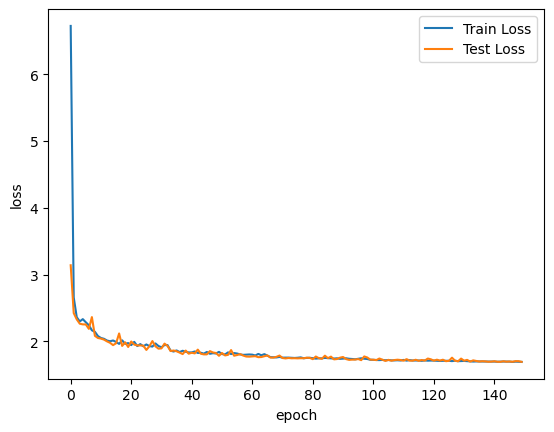

In [18]:
x = range(len(MLoss))
loss_fig = plt.figure
plt.plot(x, MLoss, label='Train Loss')
plt.plot(x, M_validation_loss, label='Test Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
loss_fig_name = 'Train-Test loss.png'
loss_fig_path = os.path.join(pic_dir, loss_fig_name)
# saving
plt.savefig(loss_fig_path)


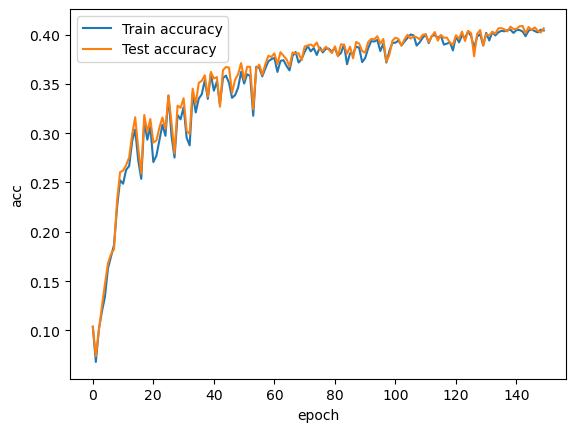

In [19]:
accuracy_fig = plt.plot(x, acc, label='Train accuracy')
plt.plot(x, acc_validation, label='Test accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
accuracy_fig_name = 'Train-Test accuracy.png'
accuracy_fig_path = os.path.join(pic_dir, accuracy_fig_name)
# Saving
plt.savefig(accuracy_fig_path)


In [20]:
# predicting test dataset
y_hat = nn.predict(test_data)
# calculating TP,FP and FN
TP = np.zeros(10)
# TN=np.zeros(10)
FP = np.zeros(10)
FN = np.zeros(10)
for i in range(len(test_data)):
    # mask=np.ones(10)
    if np.argmax(y_hat[i]) == np.argmax(test_label[i]):
        # mask[np.argmax(test_label[i])]=0
        TP[np.argmax(y_hat[i])] += 1
        # TN+=mask
    else:
        FP[np.argmax(y_hat[i])] += 1
        FN[np.argmax(test_label[i])] += 1
        # mask[np.argmax(y_hat[i])]=0
        # mask[np.argmax(test_label[i])]=0
        # TN+=mask
# calculating accuracy, precision, recall and F1-Score
accu = TP/len(test_data)
prec = TP/(TP+FP)
reca = TP/(TP+FN)
# TO avoid nan. changing all nan to 0
for i in range(len(prec)):
    if math.isnan(prec[i]):
        prec[i] = 0
for i in range(len(reca)):
    if math.isnan(reca[i]):
        reca[i] = 0
# calculating averagy
a_accu = np.sum(accu)
a_prec = np.mean(prec)
a_reca = np.mean(reca)
a_F1s = 2*a_prec*a_reca/(a_prec+a_reca)

print('Average accuracy is: {:.4f}'.format(a_accu))
print('Average precision is: {:.4f}'.format(a_prec))
print('Average recall is: {:.4f}'.format(a_reca))
print('Average F1-score is: {:.4f}'.format(a_F1s))


Average accuracy is: 0.4063
Average precision is: 0.4024
Average recall is: 0.4063
Average F1-score is: 0.4043


In [21]:
# For calculating loss of test dataset
def cross_entropy(y, y_hat):
    loss = -np.sum(y*np.log(y_hat+1e-7), axis=1)
    loss = np.mean(loss)
    return loss

In [22]:
for i in range(len(test_data)):
    added_Pre_list = np.zeros(130)
    added_Pre_list[0] = np.argmax(test_label[i])
    added_Pre_list[1] = np.argmax(y_hat[i])
    for j in range(len(test_data[i])):
        added_Pre_list[j+2]=test_data[i,j]
    Test_Predition.loc[i]=added_Pre_list
Test_Predition.to_csv('Prediction of Test dataset\\Test prediction.csv',index=None)

In [23]:
End_time=time.time()

In [24]:
added_Result_list.append(cross_entropy(test_label, y_hat))
added_Result_list.append(a_accu)
added_Result_list.append(a_prec)
added_Result_list.append(a_reca)
added_Result_list.append(a_F1s)
added_Result_list.append(End_time-Start_time)


In [28]:
# writting to analyse.csv
Test_Result.loc[0] = added_Result_list
Test_Result.to_csv('Prediction of Test dataset\\Test result.csv', index=None)
